Mean of missing values for each module:
moduleName
gov              0.334440
fee_collector    0.217427
Name: is_missing, dtype: float64


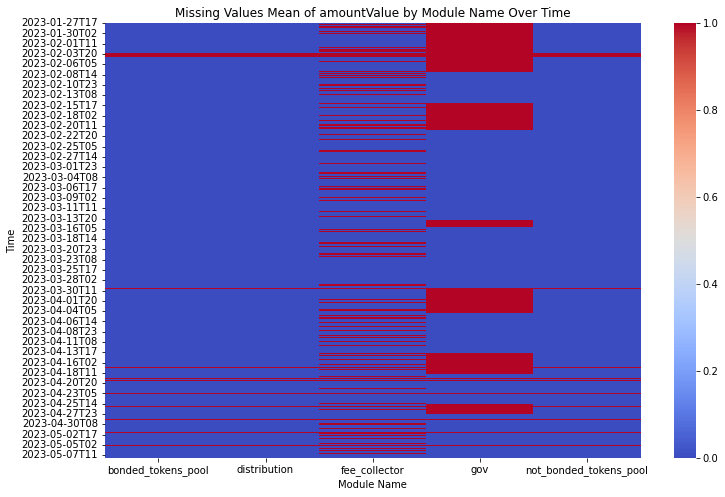

In [37]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Input file name
#input_file_name = './data/ucosmos-balance.csv'
#input_file_name = './data/ujuno-balance.csv'
#input_file_name = './data/ukava-balance.csv'
input_file_name = './data/uosmo-balance.csv'

# Load your dataset
data = pd.read_csv(input_file_name)

# Convert the '_time' column to datetime format
data['_time'] = pd.to_datetime(data['_time'])

# Filter out data before '2023-01-27T17:00:00Z'
data = data[data['_time'] >= '2023-01-27T17:00:00Z']

# Replace -1 with NaN (Null) in the dataset
data.replace(-1, pd.NA, inplace=True)

# Create a new binary column 'is_missing' to indicate if amountValue is missing
data['is_missing'] = data['amountValue'].isnull()

# Convert _time to datetime format, then reformat the string to only include the date up to the hour
data['_time'] = pd.to_datetime(data['_time']).dt.strftime('%Y-%m-%dT%H')

# Group data by moduleName and _time, then calculate the mean of 'is_missing'
missing_by_module_time = data.groupby(['moduleName', '_time'])['is_missing'].mean().reset_index()

# Pivot the data to create a table with module names as columns and time as rows for mean
missing_by_module_time_pivot_mean = missing_by_module_time.pivot_table(index='_time', columns=['moduleName'], values='is_missing', fill_value=0)

# Calculate the mean of missing values for each module and round to 6 decimal places
mean_of_missing_values = missing_by_module_time.groupby('moduleName')['is_missing'].mean().round(6)

# Find the most frequent value among the rounded values
counter = Counter(mean_of_missing_values)
most_frequent_value = counter.most_common(1)[0][0]

# Filter out the most frequent value
mean_of_missing_values = mean_of_missing_values[mean_of_missing_values != most_frequent_value]

# Sort the mean_of_missing_values in descending order
mean_of_missing_values = mean_of_missing_values.sort_values(ascending=False)

# Print the mean of missing values for each module
print("Mean of missing values for each module:")
print(mean_of_missing_values)

# Get the base name of the file (without directory) and remove the file extension
base_file_name = os.path.basename(input_file_name)
base_file_name_without_extension = os.path.splitext(base_file_name)[0]

# Define the directory where the result files will be saved
output_directory = './result-files/'

# Generate the output file name
output_file_name = output_directory + base_file_name_without_extension + '.missing-result.txt'
output_image_name = output_directory + base_file_name_without_extension + '_heatmap.png'

# Save the mean of missing values to a text file with a modified file name
mean_of_missing_values.to_csv(output_file_name, header=True)

# Append the most frequent missing value to the same output text file
with open(output_file_name, 'a') as f:
    f.write('\nMost Frequent Missing Value: ' + str(most_frequent_value))
    
# Visualize the missing values by moduleName using a heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(missing_by_module_time_pivot_mean, cmap='coolwarm', cbar=True, ax=ax)

# Set the background color to white
ax.set_facecolor('white')

# Set labels and title with a color that contrasts with the white background
plt.xlabel("Module Name", color='black')
plt.ylabel("Time", color='black')
plt.title("Missing Values Mean of amountValue by Module Name Over Time", color='black')

# Save the plot as an image file
plt.savefig(output_image_name, facecolor='white')

# Show the plot
plt.show()